In [1]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import trange

import model
from data import seq_data, grid_data
from data_analysis.visualization.visualization import hidden_repr
from preprocessing import OneHot
from compilation import Compiler, ScalarTracker, ActivationTracker


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

device = torch.device("cpu")

GPU not available, CPU used


In [2]:
## Generate data
symbols = [0, 1]
encoding = OneHot(symbols)
xor_problem = lambda seq: np.sum(seq) % 2
par_3_problem = lambda seq: int(np.sum(seq) % 3 == 2)
problem = xor_problem

train_datasets = [
    seq_data(device, problem, encoding, seq_len=1),
    seq_data(device, problem, encoding, seq_len=2),
    seq_data(device, problem, encoding, seq_len=3),
    # seq_data(device, problem, encoding, seq_len=4),
    # seq_data(device, problem, encoding, seq_len=5),
    # seq_data(device, problem, encoding, seq_len=6, n_datapoints=30),
    # seq_data(device, problem, encoding, seq_len=7, n_datapoints=30),
]

# train_datasets = [
#     seq_data(device, problem, encoding, seq_len=1, n_datapoints=2),
#     seq_data(device, problem, encoding, seq_len=5, n_datapoints=2),
#     seq_data(device, problem, encoding, seq_len=7, n_datapoints=2),
#     seq_data(device, problem, encoding, seq_len=9, n_datapoints=3),
#     seq_data(device, problem, encoding, seq_len=11, n_datapoints=2),
#     seq_data(device, problem, encoding, seq_len=12, n_datapoints=2),
# ]

val_dataset = [seq_data(device, problem, encoding, n_datapoints=10, seq_len=10)]
tracked_datasets = val_dataset + train_datasets


grid = grid_data(device, dim=2, output_dim=2, n=20, bounds=(-1, 1))


In [3]:
## Instantiate model
model = model.Model(
    encoding=encoding,
    input_size=2,
    output_size=2,
    hidden_dim=10,
    n_layers=4,
    device=device,
    init_std=0.1,
    # output_noise=0.01,
)

In [4]:
## Train

# Define hyperparameters
n_epochs = 200
lr = 0.001

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
initial_hidden = model.init_hidden(batch_size=1)[-1]
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model, lambda inputs: model(inputs)[1][-1], initial=initial_hidden
    ),
    "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
}


In [5]:
# Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=1000
)


Training: 100%|██████████| 200/200 [00:04<00:00, 42.32steps/s, train_loss=0.00013, val_loss=0.44106]


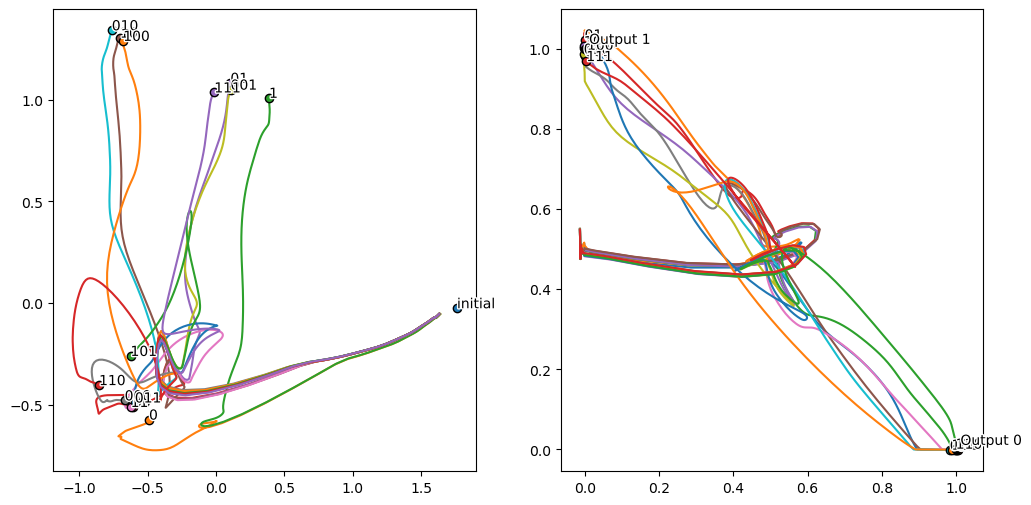

interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(width='42%'), max=199), Output())…

In [6]:
## Show evolution of hidden states
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "Epoch >= 0"
query += "and (Dataset != 0)"
# query += "and (Dataset < 3)"
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

hidden_repr(
    data_hid,
    data_output,
    transform=("PCA", "none"),
    n_labels=0,
    fig_size=6,
    encoding=encoding,
    plot_labels=True,
    # gif_path="hidden_repr",
)
# TODO Plot map A(h)
# TODO Plot pairwise distances


In [7]:
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.automata import (
    state_placement,
    layers_to_coordinates,)

z = to_automaton_history(data_hid, data_output, merge_distance=0.05)


In [8]:
z[190].transition_function

{(State(initial), '0'): State(0),
 (State(0), '0'): State(00),
 (State(00), '0'): State(000),
 (State(00), '1'): State(001),
 (State(0), '1'): State(01),
 (State(01), '0'): State(010),
 (State(01), '1'): State(011),
 (State(initial), '1'): State(1),
 (State(1), '0'): State(10),
 (State(10), '0'): State(100),
 (State(10), '1'): State(101),
 (State(1), '1'): State(11),
 (State(11), '0'): State(110),
 (State(11), '1'): State(111)}

In [9]:
z[190].states

[State(0),
 State(00),
 State(000),
 State(001),
 State(01),
 State(010),
 State(011),
 State(1),
 State(10),
 State(100),
 State(101),
 State(11),
 State(110),
 State(111),
 State(initial)]

In [10]:
state_placement(z[190])


[[State(initial)],
 [State(0), State(1)],
 [State(00), State(01), State(10), State(11)],
 [State(000),
  State(001),
  State(010),
  State(011),
  State(100),
  State(101),
  State(110),
  State(111)]]

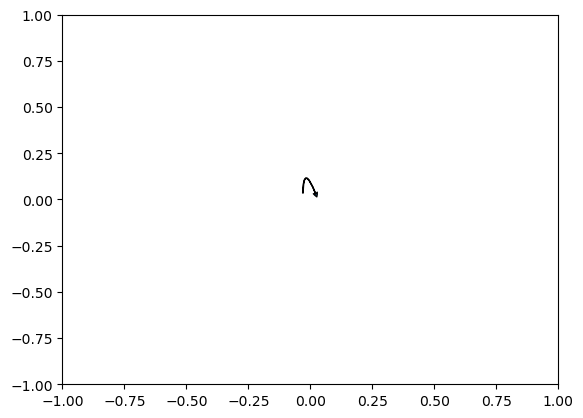

In [11]:
import matplotlib.patches as patches
from matplotlib import pyplot as plt

figure, axes = plt.subplots()
line = patches.FancyArrowPatch(
    (-0.03, 0.02),
    (0.03, 0),
    arrowstyle="Fancy,head_length=3,head_width=3",
    # connectionstyle="arc3,rad=1.5",
    connectionstyle="angle3,angleA=90, angleB=110",
)
axes.add_artist(line)
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
plt.show()


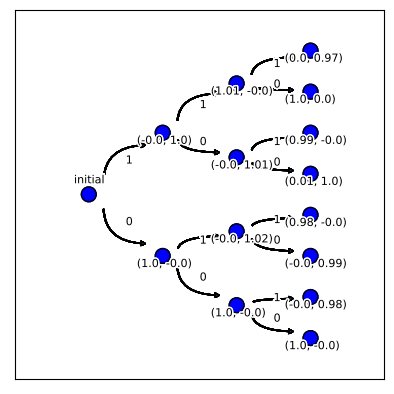

In [19]:
from data_analysis.visualization.automata import display_automata


automata = z[199]

display_automata(automata)


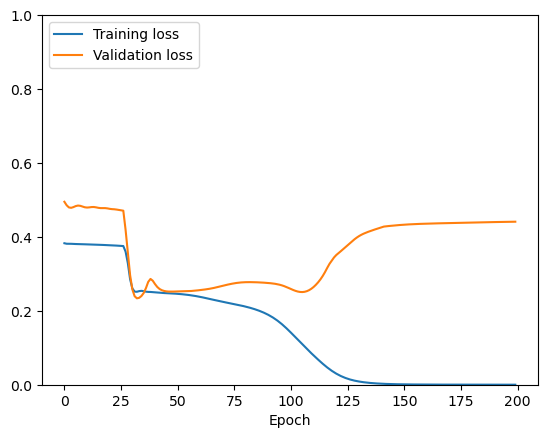

In [13]:
## Plot training and validation loss during training
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.show()

100%|██████████| 100/100 [00:00<00:00, 190.18it/s]


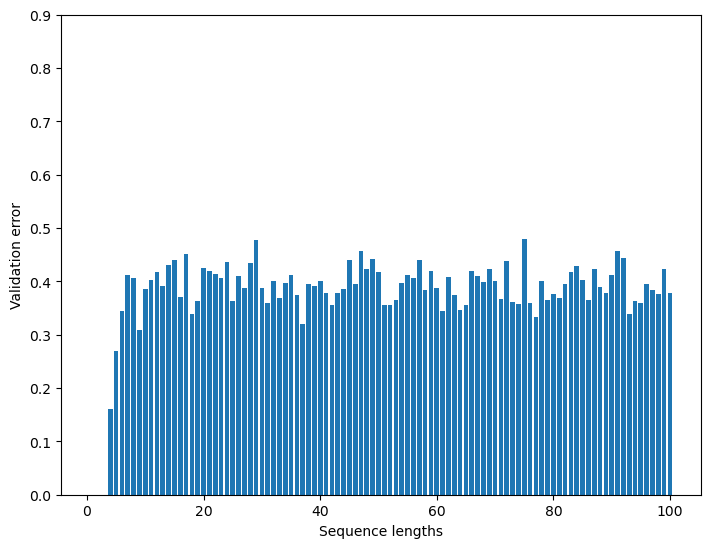

In [14]:
## Plot error per sequence length
N = 100
val_data = []
for n in trange(1, N + 1):
    val_data.append(seq_data(device, problem, encoding, n_datapoints=100, seq_len=n))
val_err = compiler.validation(val_data).to_numpy()[:, 0]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(np.arange(1, N + 1), val_err)
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
ax.set_yticks(np.arange(0, 1, 0.1))
plt.show()


In [15]:
def predict(model, sequence):
    input = torch.from_numpy(np.array([encoding(sequence)], dtype=np.float32)).to(
        device
    )
    out, hidden = model(input)
    prediction = out.cpu().detach().numpy()
    return prediction


test_seq = [0, 0, 0, 1, 0, 0, 0]
print(f"Prediction: {predict(model, test_seq)}, True output: {problem(test_seq)}")


Prediction: [[0.05320454 0.47377303]], True output: 1
